In [ ]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])

# Aula 04 - Interação de Lennard-Jones e Condição de Contorno Periódica

## Posições das Partículas em 2D

Vamos considerar 36 partículas colocados em uma caixa 2D de tamanho $L_x = L_y = 12\sigma$ onde $\sigma$ é o tamanho das partículas.

Número de átomos

In [ ]:
Nparticles = 36

Tamanho de cada partícula

**Ex:** Para Ar (argônio) temos
- $\sigma = 3,4\ \AA$

In [ ]:
sigma = ... # em unidades atômicas

Densidade de partículas

In [ ]:
rho = 0.2 # N/V

Tamanho da caixa em 2D

In [ ]:
Lx = Ly = np.sqrt(Nparticles/rho)*sigma.max()

Lx, Ly

Vamos colocar os 16 átomos de forma uniforme ao longo da caixa

In [ ]:
# Número de pontos em x e y
Nx = int(np.sqrt(Nparticles))
Ny = int(np.sqrt(Nparticles))
# ou seja, Nx.Ny = Nparticles

# Espaçamento entre os átomos
dx = Lx/Nx
dy = Ly/Ny

# Posições possíveis em x e y
xarray = ...
yarray = ...

# Cria uma grid em 2D
X,Y = np.meshgrid(xarray,yarray,indexing='ij')

# Colocando as partículas em suas posições
x0 = X.flatten()
y0 = Y.flatten()

In [ ]:
x0

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5)

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

## Velocidades das partículas

Da distribuição de Maxwell-Boltzmann sabemos que a distribuição de velocidades em cada direção deve ser uma gaussiana centrada em 0 e com variância associada à temperatura como dado em 

$$f(v_x) = \left(\frac{m}{2\pi k_B T}\right)^{1/2} \exp{\left(-\frac{m v_x^2}{2 k_B T}\right)}$$

tal que a variância dessa gaussiana seja 

$$\sigma^2 = k_B T/m$$

In [ ]:
# scale = sigma
kT = 150

v0x = ...
v0y = ...

In [ ]:
v0x

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(x0,y0,v0x,v0y,color='C0') # vetor de velocidade

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

Energia cinética $ K = \frac{m \boldsymbol{v}^2}{2}$

In [ ]:
def energia_cinetica2d(vx,vy):
    return ...

In [ ]:
K0 = energia_cinetica2d(v0x,v0y)

print(K0)

## Interação de Lennard-Jones

Para duas moléculas interagindo, podemos aproximar o potencial de interação a partir da interação de Lennard-Jones dada por 

$$u(r_{ij}) = 4\epsilon\left[ \left(\frac{\sigma}{r_{ij}} \right)^{12}-\left(\frac{\sigma}{r_{ij}} \right)^{6}\right] $$

com $\epsilon$ sendo uma energia de interação e $\sigma$ uma distância de aproximação mínima. 

Podemos definir uma distãncia de corte tal que $ u(r) = 0$ se $ r> r_\text{cut}$.

**Ex:** Para Ar (argônio) temos
- $\epsilon/k_B = 119,8$ K


In [ ]:
epsilon = ...

O potencial de LJ

In [ ]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return ...

In [ ]:
r = np.arange(0.1,10.0,0.01)

plt.plot(r,ulj(r))

plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$u(r)/\epsilon$')

plt.xlim(0,10.0)
plt.ylim(-1.0,1.0)

Podemos definir uma distãncia máxima `rcut` (um cutoff) tal que a interação de LJ seja nula a partir dela.

In [ ]:
rcut = 2.5

Derivada do potencial de LJ: $ \frac{\partial u(r)}{\partial r}$

In [ ]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return ....

A energia interna do gás é dada pela soma de interação entre os pares
$$U_{int} = \frac{1}{2}\sum_i \sum_{j \neq i} u(|\boldsymbol{r}_i-\boldsymbol{r}_j|)= \sum_i \sum_{j > i+1} u(|\boldsymbol{r}_i-\boldsymbol{r}_j|)$$

Vamos calcular a força total que atua sobre a partícula $i$ a partir do gradiente da energia potencial 

$$ \boldsymbol{F}_i = - \nabla_i U_{int} = - \frac{1}{2}\sum_{k} \sum_{j \neq k} \frac{\partial u(r_{kj})}{\partial r_{kj}} \frac{\partial r_{kj}}{\partial \boldsymbol{r}_i}=-\frac{1}{2}\sum_{k} \sum_{j \neq k} \frac{\partial u(r_{kj})}{\partial r_{kj}} \frac{(\delta_{ki}-\delta_{ij})(\boldsymbol{r}_k -\boldsymbol{r}_j)}{ |\boldsymbol{r}_k-\boldsymbol{r}_j|} = -\sum_{j \neq i} \frac{\partial u(r_{ij})}{\partial r_{ij}} \frac{\boldsymbol{r}_i-\boldsymbol{r}_j}{ |\boldsymbol{r}_i-\boldsymbol{r}_j|}$$

Definindo a função que calcula a aceleração de cada partícula e a energia interna do sistema

In [ ]:
def lennardjones2d(x,y,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            ...
    return ax, ay, U

Considerando os parâmetros do potencial de LJ e calculando a aceleração inicial

In [ ]:
a0x, a0y, U0 = lennardjones2d(x0,y0,epsilon,sigma)

print(U0)

In [ ]:
U0 + K0

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(x0,y0,v0x,v0y,color='C0') # vetor de velocidade
plt.quiver(x0,y0,a0x,a0y,color='C3') # vetor de aceleração

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

## Condição de Contorno Períodica

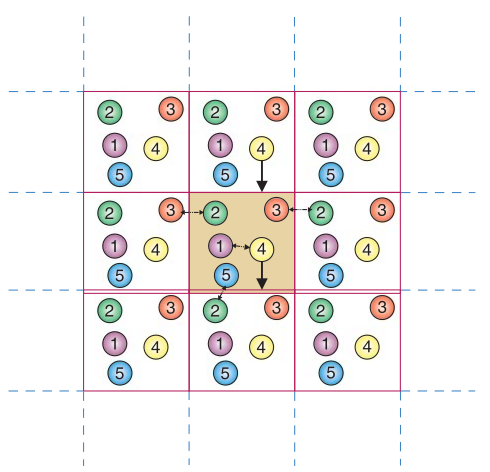

- Se x<0 faremos $ x = x + L$

- Se x>L faremos $ x = x- L$

In [ ]:
50.0 % Lx 

In [ ]:
-1.0 % Lx 

Incluindo condição de contorno periódica na interação de lennard-jones

In [ ]:
def lennardjones2d_periodica(x,y,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            ....
    return ax, ay, U

In [ ]:
a0x, a0y, U0 = lennardjones2d_periodica(x0,y0,epsilon,sigma)

print(U0)

In [ ]:
U0 + K0

## Generalizando para 3D

In [ ]:
Nparticles = 216
# Nparticles = 1000

rho = 0.6

Vol = Nparticles/rho

Lx = Ly = Lz = np.power(Vol,1/3.0)*sigma.max()

sigma = 3.4*np.ones(Nparticles) 
epsilon = 119.8*np.ones(Nparticles)

In [ ]:
# Número de pontos em x e y
Nx = int(np.round(np.power(Nparticles,1/3)))
Ny = int(np.round(np.power(Nparticles,1/3)))
Nz = int(np.round(np.power(Nparticles,1/3)))
# ou seja, Nx.Ny = Nparticles

# Espaçamento entre os átomos
dx = Lx/Nx
dy = Ly/Ny
dz = Lz/Nz

# Posições possíveis em x e y
xarray = ...
yarray = ...
zarray = ...

# Cria uma grid em 3D
X,Y, Z = np.meshgrid(xarray,yarray,zarray,indexing='ij')

# Colocando as partículas em suas posições
x0 = X.flatten()
y0 = Y.flatten()
z0 = Z.flatten()

In [ ]:
Nx

In [ ]:
# scale = sigma
kT = 150

v0x = ...
v0y = ...
v0z = ...

def energia_cinetica3d(vx,vy,vz):
    return ...

K0 = energia_cinetica3d(v0x,v0y,v0z)

In [ ]:
def lennardjones3d_periodica(x,y,z,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            ...
    return ax, ay, az, U

In [ ]:
a0x, a0y, a0z, U0 = lennardjones3d_periodica(x0,y0,z0,epsilon,sigma)

In [ ]:
K0, U0, K0+U0